**Random Forest Model**

**This script uses the rasterio and subprocess modules to warp a raster image specified by 'image_ds_path' to a new extent, coordinate reference system (CRS), and resolution. It then saves the warped image as 'trainingAlgonquinWarp.tif' using GDAL's gdalwarp command-line utility.**

In [1]:
import rasterio
import subprocess
import joblib

# Read in our image and training / testing samples
training_ds_original = "trainingAlgonquin.tif" # Original training dataset path
training_ds_path = "trainingAlgonquinWarp.tif" # Desired warped training ds path

image_ds_path = "/Users/maciej/Library/CloudStorage/OneDrive-UniversityofGuelph/Grad School/Winter 2024/GEOG 6550/Project Folder/Updated RCM Imagery and Decompositions/Image Stacks/S1 & Terrain/S1_Terrain.tif"
model_desc = "S1_Terrain" #Update with naming convention for model outputs

# Load the trained Random Forest model
rf = joblib.load(f"{model_desc}_model.pkl")

target_file = image_ds_path
with rasterio.open(target_file) as src:
    profile = src.profile

aff = profile['transform']
width = profile['width']
height = profile['height']
crs = profile['crs']['init']

xmin = aff[2]
xmax = aff[2] + width*aff[0]
ymax = aff[5]
ymin = aff[5] + height*aff[4]


command = [
    'gdalwarp',
    '-te', str(xmin), str(ymin), str(xmax), str(ymax),
    '-te_srs', crs,
    '-t_srs', crs,
    '-tr', '30', '30',
    '-tap',
    '-co', 'COMPRESS=LZW',
    '-overwrite',
    training_ds_original,
    training_ds_path
]


subprocess.call(command)

print(width, height)


Creating output file that is 4330P x 3687L.
Processing trainingAlgonquin.tif [1/1] : 0Using internal nodata values (e.g. -999) for image trainingAlgonquin.tif.
Copying nodata values from source trainingAlgonquin.tif to destination trainingAlgonquinWarp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
4330 3687


**This script prepares raster data for further analysis by reading both the image and training data into NumPy arrays**

In [2]:
# Import Python 3's print function and division
from __future__ import print_function, division
 
# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

img_ds = gdal.Open(image_ds_path, gdal.GA_ReadOnly)     #Image Dataset
dataset = gdal.Open(training_ds_path, gdal.GA_ReadOnly) #Training Dataset


img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
 
ds = dataset.GetRasterBand(1).ReadAsArray().astype(np.uint8)


print(ds.shape)
print(img.shape)

height = img.shape[0]
width = img.shape[1]
depth = img.shape[2]
print("Height:", height, "Width", width, "Depth:", depth)
 

(3687, 4330)
(3687, 4330, 27)
Height: 3687 Width 4330 Depth: 27


**This script performs stratified random sampling to split a dataset into training and test subsets while maintaining class distribution. It then uses the `train_test_split` function from scikit-learn to split the sampled data into training and testing subsets, ensuring reproducibility by setting the random seed `SEED`.**


In [3]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Import the classification report and accuracies
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Set seed for reproducibility
SEED = np.random.seed(1234)  # Set the seed using numpy

X = img.reshape((width*height, depth))
y = ds.flatten()

# Split dataset into training set and test set
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Stratified random sampling
fraction = 0.2          #Define what fraction of all samples should be used for training/validation
min_samples = 2000      #Define the minimum # of sample to be used by any given class
Xsample = []
ysample = []
for i in range(1, 9):  #We ignore class 0 here which is noData
    Ntotal = (y == i).sum()
    Nsample = max(int(fraction*Ntotal), min_samples)
    idx = np.where(y == i)[0]
    s_idx = np.random.choice(idx, Nsample)
    Xsample.append(X[s_idx,:])
    ysample.append(np.repeat(i, Nsample))

Xsample = np.vstack(Xsample)
ysample = np.hstack(ysample)

# Split the data with the seeded random_state
X_train, X_test, y_train, y_test = train_test_split(Xsample, ysample, test_size=0.3, random_state=SEED) # 70% training and 30% test


Shape of X: (15964710, 27)
Shape of y: (15964710,)


In [ ]:
np.unique(y_train)      #Prints the number of unique classes found within the sample subset

**The randomForest model is fit to the training data and saved**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# User-defined number of decision trees
trees = 500  # Default = 100, can be changed

# Initialize our model with the specified hyperparameters
rf = RandomForestClassifier(n_estimators=trees, n_jobs=-2, verbose=3) # specify trees, use all but one core, display progress

# Fit our model to training data
rf = rf.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(rf, f"{model_desc}_model.pkl")


**Model Stats**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = rf.predict(X_test)

print('Precision: ', precision_score(y_test, y_pred, average = None))
print('\nRecall: ', recall_score(y_test, y_pred, average = None))
print('\nF1: ',f1_score(y_test, y_pred, average = None))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Calculate precision, recall, F1 scores, and AUC for each class
precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)
f1_scores = f1_score(y_test, y_pred, average=None)
auc_scores = [roc_auc_score((y_test == i).astype(int), (y_pred == i).astype(int)) for i in range(1, 9)]

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
overall_accuracy = round(overall_accuracy, 4)

# Define class names
class_names = ['Fen', 'Swamp', 'Marsh', 'Bog', 'Open Water', 'Forest', 'Vegetated Land', 'Barren Land']

# Create bar plots
plt.figure(figsize=(12, 8))
plt.bar(np.arange(len(class_names)) - 0.22, precision_scores, width=0.15, label="Precision (Producer's Accuracy)", color='skyblue', edgecolor='black')
plt.bar(np.arange(len(class_names)) - 0.07, recall_scores, width=0.15, label="Recall (User's Accuracy)", color='lightgreen', edgecolor='black')
plt.bar(np.arange(len(class_names)) + 0.08, f1_scores, width=0.15, label='F1 Score', color='orange', edgecolor='black')
plt.bar(np.arange(len(class_names)) + 0.23, auc_scores, width=0.15, label='AUC', color='red', edgecolor='black')
plt.axhline(overall_accuracy, color='black', linestyle='--', label=f'Overall Accuracy ({overall_accuracy})')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.xlabel('Class', fontsize=12, weight='bold')
plt.ylabel('Score', fontsize=12, weight='bold')
plt.title(f'Precision, Recall, F1 Score, AUC, and OA with {model_desc} ({trees} Trees)', fontsize=14, weight='bold')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

# Set y-axis grid every 0.1
plt.yticks(np.arange(0, 1.1, 0.1))

# Add y-axis grid with subdivisions
plt.grid(axis='y', which='major', color='gray', linestyle='--', linewidth=0.5)

# Save the figure
plt.savefig(f'Figures/{model_desc}_Bargraph.png', bbox_inches='tight')  # Adjust the filename and path as needed

plt.show()


**Confusion Matrix Creation**

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['Fen', 'Swamp', 'Marsh', 'Bog', 'Open Water', 'Forest', 'Vegetated Land', 'Barren Land']

# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names, 
                 annot_kws={"size": 12, "weight": "bold"}, cbar=False)
plt.xlabel('Predicted', fontsize=12, weight='bold')
plt.ylabel('Actual', fontsize=12, weight='bold')
plt.title(f'Confusion Matrix with {model_desc} ({trees} Trees)', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add color scale bar
cbar = ax.figure.colorbar(ax.collections[0], ax=ax, location='right', pad=0.05)
cbar.set_label('Number of Instances', fontsize=12, weight='bold')

# Save the figure
plt.savefig(f'Figures/{model_desc}_Matrix.png', bbox_inches='tight')  # Adjust the filename and path as needed

plt.show()

**The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for various classification thresholds. It illustrates how well the classifier can distinguish between positive instances and negative instances across different thresholds. Can be used to assess discriminative power and overall performance.**

**Display feature importances**

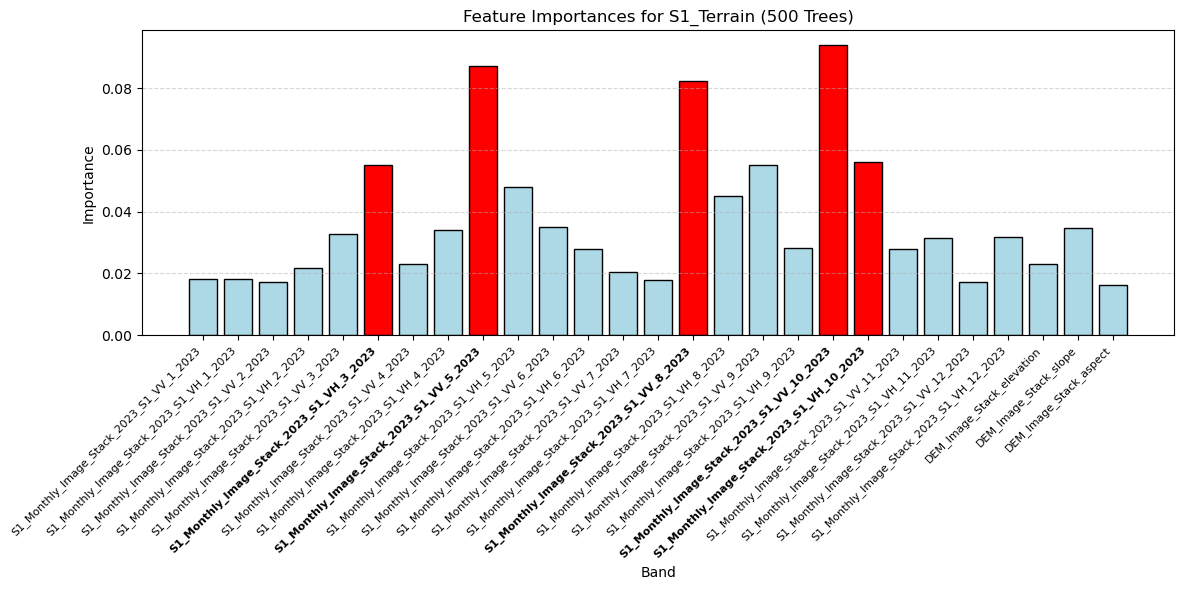

In [4]:
from sklearn.ensemble import RandomForestClassifier
import rasterio
import joblib
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = rf.feature_importances_

# Open the raster dataset to obtain band names
with rasterio.open(image_ds_path) as dataset:
    # Read the band names
    band_names = dataset.descriptions

# Get the number of bands
num_bands = len(band_names)

# Define the bar width to create some padding
bar_width = 0.8

# Plot feature importances with band names as labels
plt.figure(figsize=(12, 6))
bars = plt.bar(range(num_bands), importances, align='center', color='lightblue', edgecolor='black', width=bar_width)

# Highlight the top 5 bar features in red and bold the label text
top_indices = importances.argsort()[-5:][::-1]
for i, bar in enumerate(bars):
    if i in top_indices:
        bar.set_color('red')
        bar.set_edgecolor('black')
        plt.xticks(range(num_bands), band_names, rotation=45, ha='right', fontsize=8)  # Resetting tick labels
    
# Bold the labels for the top 5 bands
plt.xticks(range(num_bands), band_names, rotation=45, ha='right', fontsize=8)
for i, tick in enumerate(plt.gca().get_xticklabels()):
    if i in top_indices:
        tick.set_weight('bold')  # Bold the label text for top 5 bands

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Set x-axis label, y-axis label, and title
plt.xlabel('Band')
plt.ylabel('Importance')
plt.title(f'Feature Importances for {model_desc} (500 Trees)')

# Show the plot
plt.tight_layout()

# Save the figure
plt.savefig(f'Figures/{model_desc}_FeatureImportances.png', bbox_inches='tight')  # Adjust the filename and path as needed

plt.show()


**Create a classified .tif**

In [ ]:
covariate_image_file = image_ds_path
with rasterio.open(covariate_image_file) as src:
    output_meta = src.profile

output_meta.update(count = 1, dtype = np.uint8, nodata = 255, compress = 'lzw')

output_classified_file = f"{model_desc}_Classified.tif"

def predict_row(row):
    w = ((row,row+1), (None, None))
    with rasterio.open(covariate_image_file) as src:
        nodata = src.profile['nodata']
        X = src.read(window = w)[:,0,:]
    y_pred = rf.predict(X.T)
    mask = np.where((X == nodata).any(axis = 0))
    y_pred[mask] = 255
    
    return y_pred


out_ds = rasterio.open(output_classified_file, "w", **output_meta)

try:
    print(f"Predicting {output_meta['height']} rows:", flush = True)
    for row in range(output_meta['height']):
        if row % 100 == 0:
            print(row, "...", sep = '', end = '', flush = True)
        y_pred = predict_row(row).reshape((1, output_meta['width']))
        w = ((row, row+1), (None, None))
        out_ds.write_band(1, y_pred, window = w)
    print("done.")
finally:
    out_ds.close()


**0 = NoData   
1 = Fen   
2 = Swamp   
3 = Marsh   
4 = Bog   
5 = Open Water   
6 = Forest   
7 = Vegetated Land   
8 = Barren Land**